In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
#locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [20]:
datos = []
for dirname, dirnames, filenames in os.walk('../esamu/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['../esamu/SAMU 01-01-2020 al 31-03-2020.xlsx',
 '../esamu/SAMU 01-01-2018 al 31-12-2018.xlsx',
 '../esamu/SAMU 01-01-2019 al 31-12-2019.xlsx']

selecciono algunos...

In [21]:
archivos_eSAMU = [f for f in datos if '.xls' in f]

dejo todo lo que tengo como un solo objeto: BD

In [22]:
BD = pd.DataFrame()
for f in archivos_eSAMU:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115387 entries, 0 to 53351
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Id                        115387 non-null  int64  
 1   Fecha                     115387 non-null  object 
 2   Motivo del Llamado        115380 non-null  object 
 3   Submotivo del Llamado     115380 non-null  object 
 4   Prioridad                 84148 non-null   object 
 5   Estado                    115387 non-null  object 
 6   Edad                      110017 non-null  float64
 7   Género                    109630 non-null  object 
 8   Dirección                 99520 non-null   object 
 9   Sector                    78263 non-null   object 
 10  Comuna                    103587 non-null  object 
 11  Región                    112547 non-null  object 
 12  Intervención              115387 non-null  object 
 13  Tipo Traslado             115387 non-null  ob

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [23]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [24]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S').copy()

In [25]:
BD['Fecha'].describe()

count                  115387
unique                 100693
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-03-31 23:53:04
Name: Fecha, dtype: object

Luego defino aquellas variables que debo hacer algo similar

In [26]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado',
    'En Regulación', 'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado'
]

 aparte...... hay un prolema '-03'...no se de donde salió....
    pero trato de corregirlo

In [27]:
dumm = BD.copy()

In [28]:
dumm['Móvil Despachado']

0        Sin vehículo Asociado
1        Sin vehículo Asociado
2          2020-04-01 00:17:01
3          2020-03-31 23:32:55
4          2020-03-31 23:41:50
                 ...          
53347    Sin vehículo Asociado
53348      2019-01-01 00:49:06
53349    Sin vehículo Asociado
53350      2019-01-01 00:39:27
53351    Sin vehículo Asociado
Name: Móvil Despachado, Length: 115387, dtype: object

ahora lo hago

In [29]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [30]:
pd.to_datetime(BD['Móvil Despachado'],
              errors='coerce'
              )

0                       NaT
1                       NaT
2       2020-04-01 00:17:01
3       2020-03-31 23:32:55
4       2020-03-31 23:41:50
                ...        
53347                   NaT
53348   2019-01-01 00:49:06
53349                   NaT
53350   2019-01-01 00:39:27
53351                   NaT
Name: Móvil Despachado, Length: 115387, dtype: datetime64[ns]

In [31]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [32]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2020-03-31 23:53:04,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,144550
1,2020-03-31 23:42:58,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,144549


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,NaT,NaT,NaT,NaT,NaT,NaT
1,NaT,NaT,NaT,NaT,NaT,NaT


count                  115387
unique                 100693
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-03-31 23:53:04
Name: Fecha, dtype: object

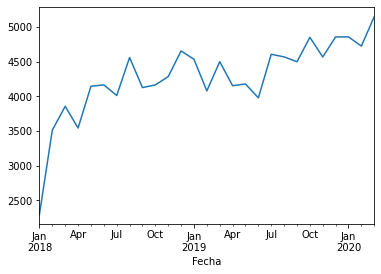

In [33]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [34]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,115386,100.0
True,1,0.0
Total,115387,100.0


,n,%
Diff_Despacho_Salida,,
False,115383,100.0
True,4,0.0
Total,115387,100.0


,n,%
Diff_salida_enellugar,,
False,115328,99.95
True,59,0.05
Total,115387,100.00


,n,%
Diff_z6_1,,
False,115384,100.0
True,3,0.0
Total,115387,100.0


,n,%
Diff_z6_2,,
False,114744,99.44
True,643,0.56
Total,115387,100.00


,n,%
Diff_z6_3,,
False,113993,98.79
True,1394,1.21
Total,115387,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [35]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [36]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,115387,100.0
Total,115387,100.0


count                     55465
mean     0 days 00:59:50.361651
std      0 days 03:41:42.110619
min             0 days 00:00:07
25%             0 days 00:06:24
50%             0 days 00:14:35
75%             0 days 00:53:24
max            13 days 15:06:32
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,115387,100.0
Total,115387,100.0


count                     44245
mean     0 days 00:07:48.923290
std      0 days 00:18:25.740566
min             0 days 00:00:02
25%             0 days 00:00:47
50%             0 days 00:03:03
75%             0 days 00:07:50
max             1 days 02:44:39
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,115387,100.0
Total,115387,100.0


count                     35314
mean     0 days 00:15:35.367446
std      0 days 00:21:02.958278
min             0 days 00:00:01
25%             0 days 00:05:02
50%             0 days 00:10:22
75%             0 days 00:18:24
max             0 days 15:34:05
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,115387,100.0
Total,115387,100.0


count                      6012
mean     0 days 01:41:52.310379
std      0 days 01:03:33.575289
min             0 days 00:00:03
25%      0 days 01:02:44.750000
50%      0 days 01:27:08.500000
75%             0 days 02:02:04
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,115387,100.0
Total,115387,100.0


count                       943
mean     0 days 01:47:05.847295
std      0 days 02:16:39.570113
min             0 days 00:00:02
25%      0 days 00:12:22.500000
50%             0 days 01:01:22
75%      0 days 02:25:18.500000
max             0 days 15:18:50
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,115387,100.0
Total,115387,100.0


count                      2285
mean     0 days 02:10:09.645951
std      0 days 02:24:58.111731
min             0 days 00:00:02
25%             0 days 00:33:59
50%             0 days 01:22:16
75%             0 days 02:54:35
max             1 days 04:20:28
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [37]:
BD.to_pickle('../eSAMU.pkl')

# Datos generales

In [38]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

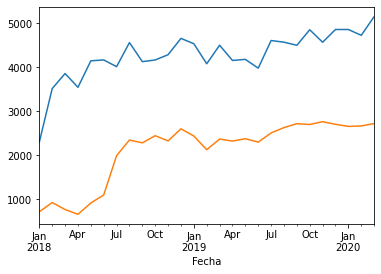

In [39]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

Text(0.5, 0, 'Edad')

Text(0, 0.5, 'Motivo Llamada')

Text(0.5, 1.0, 'Boxplot de edad según motivo llamada')

Text(0.5, 0.98, '')

(0.0, 100.0)

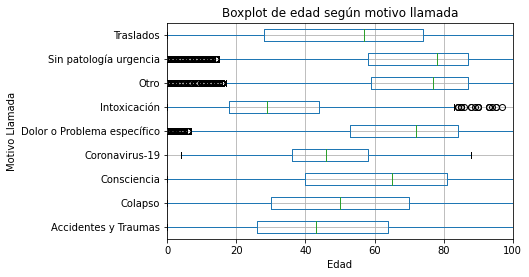

In [40]:
BD.boxplot('Edad', by = 'Motivo del Llamado', vert=False)
plt.xlabel('Edad')
plt.ylabel('Motivo Llamada')
plt.title('Boxplot de edad según motivo llamada')
plt.suptitle('')
plt.xlim([0,100])


cantidad de REM ingresados a eSAMU

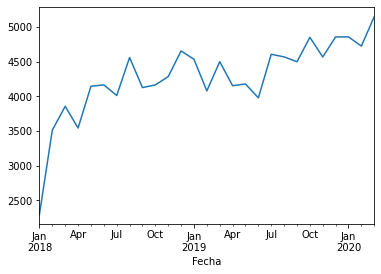

In [41]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

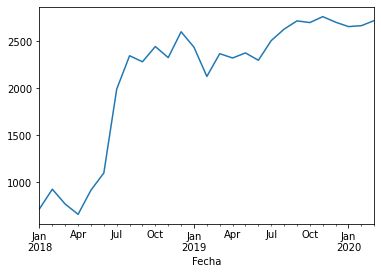

In [42]:
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()